In [1]:
!pip install git+https://github.com/kunguz/odak.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/kunguz/odak.git to /tmp/pip-req-build-8c2m3cbj
  Running command git clone -q https://github.com/kunguz/odak.git /tmp/pip-req-build-8c2m3cbj
     |████████████████████████████████| 3.1 MB 5.2 MB/s 
  Created wheel for odak: filename=odak-0.2.1-py3-none-any.whl size=116322 sha256=85813cbe3e23b41db738b224007794fa7a40158e8cdb7f9d48bbec343c9354f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-dncy2i40/wheels/5b/1f/1a/1d2de547c1d893422b054c9aea06da6ce4efbf401114444959
Successfully built odak
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


In [2]:
!pip install numpy-stl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
import odak 
import math
from stl import mesh


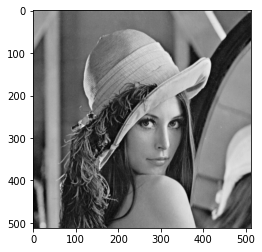

In [4]:
img = cv2.imread('/content/Lenna.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap='gray')

In [5]:
device = torch.device('cpu')

In [6]:

img_gray= cv2.resize(img_gray, (100, 100))
img_G= torch.tensor(img_gray).to(device)



In [14]:
def aperture_array(dimensions=[0.1, 0.15], pixel_count=[100, 100], Z=0.):
        x = torch.linspace(-dimensions[0]/2., dimensions[0]/2., pixel_count[0])
        y = torch.linspace(-dimensions[1]/2., dimensions[1]/2., pixel_count[1])
        X, Y = torch.meshgrid(x, y, indexing='ij')
        aperture_array_locations = torch.zeros(X.shape[0], X.shape[1], 3).to(device)
        aperture_array_locations[:, :, 0] = X
        aperture_array_locations[:, :, 1] = Y
        aperture_array_locations[:, :, 2] = Z
        aperture_array = torch.rand(X.shape[0], X.shape[1], requires_grad=True)

        return aperture_array_locations, aperture_array



In [38]:
dimensions = [0.01, 0.015]
pixel_count= [100, 100]
Z= 0.05
x = torch.linspace(-dimensions[0], dimensions[0], pixel_count[0])
y = torch.linspace(-dimensions[1], dimensions[1], pixel_count[1])
X, Y = torch.meshgrid(x, y, indexing='ij')
Points = torch.zeros(X.shape[0], X.shape[1], 3).to(device)
Points[:, :, 0] = X
Points[:, :, 1] = Y
Points[:, :, 2] = Z

# abitrary points of intersection randomly generated
Points= Points.view(-1, 3) 



array_loc, array= aperture_array()
# Location of aperture array
array_loc= array_loc.view(-1, 3)
# Intersection points and paint an image on a detector?

focal_length= torch.tensor([80,80]).to(device) 
#World coordinate origin




# Camera clocation is where the arrays are
camera_location=array_loc


W=torch.tensor([0.,0., 0.])

# Creating the pinhole intrinsic matrix
camera_Intrinsic= torch.tensor([[focal_length[0], 0., 0.],
                    [0.,focal_length[1], 0.], 
                    [0., 0., 1.]]).to(device)


# Creating extrinsic parameters(example)
Rotation= torch.tensor([[1., 0., 0.],
                  [0., 1., 0.], 
                  [0., 0., 1.]]).to(device)

one=torch.tensor([1]).to(device)
coordinates= []


for i in range(len(Points)):

  trans = (W-camera_location[i]).view(3, 1)
  t = -torch.matmul(Rotation, trans)
 
  # rotation and translation matrix(3x4)
  Rt = torch.cat((Rotation, t), 1)

  # the projection matrix
  P_mat = torch.matmul(camera_Intrinsic, Rt)

  # make point 4X1
  new_P = torch.hstack((Points[i], one)).view(4, 1)
  new_P =new_P.type(torch.float)
  cam_cood = torch.matmul(P_mat, new_P).flatten()


  # camera_coods
  u = int(cam_cood[0]/cam_cood[2])
  v = int(cam_cood[1]/cam_cood[2])

  result = [u, v]

  coordinates.append(result )

In [39]:
cam_cood

tensor([4.8000, 7.2000, 0.0500])

In [40]:

F_coords = torch.tensor(coordinates).to(device)

F_coords=F_coords.view(100, 100, 2)

S = F_coords.size()
F_coords

tensor([[[ -96, -144],
         [ -96, -141],
         [ -96, -138],
         ...,
         [ -96,  138],
         [ -96,  141],
         [ -96,  144]],

        [[ -94, -144],
         [ -94, -141],
         [ -94, -138],
         ...,
         [ -94,  138],
         [ -94,  141],
         [ -94,  144]],

        [[ -92, -144],
         [ -92, -141],
         [ -92, -138],
         ...,
         [ -92,  138],
         [ -92,  141],
         [ -92,  144]],

        ...,

        [[  92, -144],
         [  92, -141],
         [  92, -138],
         ...,
         [  92,  138],
         [  92,  141],
         [  92,  144]],

        [[  94, -144],
         [  94, -141],
         [  94, -138],
         ...,
         [  94,  138],
         [  94,  141],
         [  94,  144]],

        [[  96, -144],
         [  96, -141],
         [  96, -138],
         ...,
         [  96,  138],
         [  96,  141],
         [  96,  144]]])

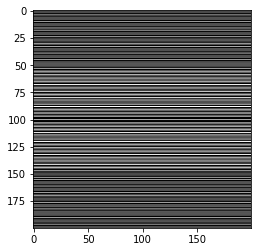

In [48]:
#F_coords = torch.tensor(coordinates).to(device)

 # create an empty image 
detector = torch.zeros((200, 200)).to(device)

for i in range(S[0]):
  for j in range(S[1]):
  
    detector[F_coords[i,j]] += array[i,j]


plt.imshow(detector.detach().cpu().numpy(), cmap='gray')